You are supposed to train and apply a boosting model for landcover classification. Below, you can find some code that already parses the data. For your submission, run and submit the extended jupyter notebook.

In [30]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.metrics import accuracy_score

In [20]:
# load data
train = np.load('./train.npz')
X_train = train["X"]
y_train = train["y"].reshape((-1,1))

test = np.load('./test.npz')
X_test = test["X"]
y_test = test["y"].reshape((-1,1))

classes = {
    1: "cultivated_land",
    2: "forest",
    3: "grassland",
    4: "shrubland",
    5: "water",
    8: "artificial_surface",
    9: "bareland"
}


In [21]:
print("Shape of training data: {}".format(X_train.shape))
print("Shape of training labels: {}".format(y_train.shape))
print("Shape of test data: {}".format(X_test.shape))
print("Shape of test labels: {}".format(y_test.shape))

Shape of training data: (6953, 12, 13, 13, 6)
Shape of training labels: (6953, 1)
Shape of test data: (1739, 12, 13, 13, 6)
Shape of test labels: (1739, 1)


The training and test set contain a few thousand instances. Each instance is based on image of size 13x13 pixels, which are available for 12 timestamps and 6 bands. That is, one is given an array of shape (12,13,13,6) for each instance. The label arrays contain the labels associated with the instances, where the central pixel/position determines the class of the (whole) image array for each instance, see below.

In [22]:
# visualize some of the (image) data

# import matplotlib.cm as cm
# import matplotlib.pyplot as plt

# idx = 0

# print("Label (i.e., class of pixel in the center of the images) for image sequence: {}".format(classes[y_train[idx,0]]))

# for year in range(12):
#     fig, axs = plt.subplots(1, 6, figsize=(24, 4))
#     for b in range(6):
#         axs[b].imshow(X_train[idx, year, :, :, b], cmap=plt.get_cmap("Greys"))
#         axs[b].set_title("Band {}".format(b+1))

# Preproccesing

In [23]:
# Count occurrences of each number in the array
def calculate_distribution(input):
    unique, counts = np.unique(input, return_counts=True)
    counter = dict(zip(unique, counts))

    total = len(input)

    for number, count in counter.items():
        percentage = (count / total) * 100
        class_name = classes.get(number, "Unknown class")
        print(f"Class {class_name} (number {number}): {percentage:.2f}%")
    print("\n")

calculate_distribution(y_test)

Class cultivated_land (number 1): 2.53%
Class forest (number 2): 66.42%
Class grassland (number 3): 12.88%
Class shrubland (number 4): 8.80%
Class water (number 5): 0.75%
Class artificial_surface (number 8): 2.42%
Class bareland (number 9): 6.21%




In [24]:
# We extract only the center pixed of each image sequence, such taht 1 pixel x 6 bands x 12 timestamps = 72 features
def extract_central_pixel(data):
    central_pixel = data[:, :, 6, 6, :]
    feature_vectors = central_pixel.reshape(data.shape[0], -1)
    return feature_vectors

X_train = extract_central_pixel(X_train)
X_test = extract_central_pixel(X_test)


In [25]:
print("X_train: ", X_train.shape, ", X_test: ", X_test.shape) # Should be (6953, 72)

X_train:  (6953, 72) , X_test:  (1739, 72)


# AdaBoost 

In [26]:
warnings.filterwarnings('ignore')
# Define estimator and classifier
base_estimator = DecisionTreeClassifier(criterion='gini')
ada_boost = AdaBoostClassifier(base_estimator=base_estimator)

param_grid = {
    'base_estimator__max_depth': [1, 2, 3],  # Depth of each decision tree
    'n_estimators': [50, 100, 200]  # Number of boosted trees
}

# Initialize GridSearchCV with 2-fold cross-validation
grid_search = GridSearchCV(ada_boost, param_grid, cv=2, verbose=3)

# Fit the GridSearchCV model
grid_search.fit(X_train, y_train)

# Get the best parameters and the performance of the best model
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[CV 1/2] END base_estimator__max_depth=1, n_estimators=50;, score=0.698 total time=   1.2s
[CV 2/2] END base_estimator__max_depth=1, n_estimators=50;, score=0.640 total time=   1.2s
[CV 1/2] END base_estimator__max_depth=1, n_estimators=100;, score=0.688 total time=   2.4s
[CV 2/2] END base_estimator__max_depth=1, n_estimators=100;, score=0.640 total time=   2.4s
[CV 1/2] END base_estimator__max_depth=1, n_estimators=200;, score=0.674 total time=   4.6s
[CV 2/2] END base_estimator__max_depth=1, n_estimators=200;, score=0.636 total time=   4.8s
[CV 1/2] END base_estimator__max_depth=2, n_estimators=50;, score=0.659 total time=   2.1s
[CV 2/2] END base_estimator__max_depth=2, n_estimators=50;, score=0.703 total time=   2.2s
[CV 1/2] END base_estimator__max_depth=2, n_estimators=100;, score=0.635 total time=   4.6s
[CV 2/2] END base_estimator__max_depth=2, n_estimators=100;, score=0.660 total time=   4.5s
[CV 1/2] END base_estimator__max_depth=2, n_estimators=200;, score=0.603 total time=

({'base_estimator__max_depth': 3, 'n_estimators': 200}, 0.7296137315973819)

Retraining of the model on the entire dataset using the parameters from gridsearch

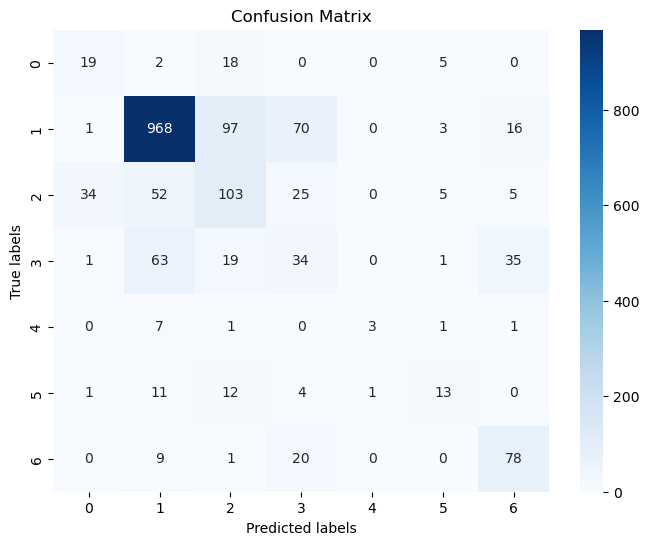

In [27]:
# Model
ada_boost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=200
)
ada_boost_model.fit(X_train, y_train)

# Predictions
y_pred = ada_boost_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
calculate_distribution(y_pred)

Class cultivated_land (number 1): 3.22%
Class forest (number 2): 63.94%
Class grassland (number 3): 14.43%
Class shrubland (number 4): 8.80%
Class water (number 5): 0.23%
Class artificial_surface (number 8): 1.61%
Class bareland (number 9): 7.76%




In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 70.04%
